In [1]:
%load_ext autoreload
%autoreload 2

### Download and destripe AP data from an IBL session by its PID.

In [2]:
from analysis.data_gen_utils import download_IBL, extract_IBL, make_dataset, combine_datasets, all_units_except
import numpy as np
import matplotlib.pyplot as plt
import os

2023-12-01 00:33:39.414516: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 00:33:39.448611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 00:33:39.448652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 00:33:39.449362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 00:33:39.454265: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 00:33:39.454735: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
pid_sess1 = r'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
pid_sess2 = r'febb430e-2d50-4f83-87a0-b5ffbb9a4943'

save_dir = r'/mnt/data/noah/IBL_data_CEED/'

cache_folder = save_dir + r'cache'

save_folder_sess1 = save_dir + pid_sess1
save_folder_sess2 = save_dir + pid_sess2

t_window = [0, 1000] #in seconds
overwrite = False
rec1, meta_file_sess1 = download_IBL(pid=pid_sess1, cache_folder = cache_folder, t_window=t_window, save_folder=save_folder_sess1, overwrite=overwrite)
rec2, meta_file_sess2 = download_IBL(pid=pid_sess2, cache_folder = cache_folder, t_window=t_window, save_folder=save_folder_sess2, overwrite=overwrite)

INFO:one.api:cache over 92 day(s) old
INFO:one.api:No newer cache available
Downloading: /mnt/data/noah/IBL_data_CEED/cache/danlab/Subjects/DY_016/2020-09-12/001/raw_ephys_data/probe00/chunk_000000_to_000999pOymoELgyv/_spikeglx_ephysData_g0_t0.imec0.ap.8cb6749e-846b-4c1e-94da-2d026c410921.cbin Bytes: 9154205766


100%|█████████████| 8730.130926132202/8730.130926132202 [11:59<00:00, 12.13it/s]


Old dir:  ['_spikeglx_ephysData_g0_t0.imec0.ap.stream.cbin', '_spikeglx_ephysData_g0_t0.imec0.ap.stream.meta', '_spikeglx_ephysData_g0_t0.imec0.ap.stream.ch']
converting files to drop "stream" from path
New dir:  ['_spikeglx_ephysData_g0_t0.imec0.ap.ch', '_spikeglx_ephysData_g0_t0.imec0.ap.stream.cbin', '_spikeglx_ephysData_g0_t0.imec0.ap.meta', '_spikeglx_ephysData_g0_t0.imec0.ap.cbin', '_spikeglx_ephysData_g0_t0.imec0.ap.stream.meta', '_spikeglx_ephysData_g0_t0.imec0.ap.stream.ch']
Folder '/mnt/data/noah/IBL_data_CEED/dab512bd-a02d-4c1f-8dbc-9155a163efc0' overwritten.
tdir:  /mnt/data/noah/IBL_data_CEED/cache/danlab/Subjects/DY_016/2020-09-12/001/raw_ephys_data/probe00/chunk_000000_to_000999pOymoELgyv
pth:  [PosixPath('/mnt/data/noah/IBL_data_CEED/cache/danlab/Subjects/DY_016/2020-09-12/001/raw_ephys_data/probe00/chunk_000000_to_000999pOymoELgyv/_spikeglx_ephysData_g0_t0.imec0.ap.stream.cbin'), PosixPath('/mnt/data/noah/IBL_data_CEED/cache/danlab/Subjects/DY_016/2020-09-12/001/raw_ep

write_binary_recording:   0%|          | 0/1000 [00:00<?, ?it/s]

done preprocessing
INFO:one.api:cache over 92 day(s) old
INFO:one.api:No newer cache available
Downloading: /mnt/data/noah/IBL_data_CEED/cache/danlab/Subjects/DY_009/2020-02-27/001/raw_ephys_data/probe00/chunk_000000_to_000999yEpzDrkimO/_spikeglx_ephysData_g0_t0.imec0.ap.628241b1-657d-4854-8dab-c7af86553db4.cbin Bytes: 8890747295


100%|█████████████| 8478.877348899841/8478.877348899841 [13:27<00:00, 10.50it/s]


Old dir:  ['_spikeglx_ephysData_g0_t0.imec0.ap.stream.cbin', '_spikeglx_ephysData_g0_t0.imec0.ap.stream.meta', '_spikeglx_ephysData_g0_t0.imec0.ap.stream.ch']
converting files to drop "stream" from path
New dir:  ['_spikeglx_ephysData_g0_t0.imec0.ap.ch', '_spikeglx_ephysData_g0_t0.imec0.ap.stream.cbin', '_spikeglx_ephysData_g0_t0.imec0.ap.meta', '_spikeglx_ephysData_g0_t0.imec0.ap.cbin', '_spikeglx_ephysData_g0_t0.imec0.ap.stream.meta', '_spikeglx_ephysData_g0_t0.imec0.ap.stream.ch']
tdir:  /mnt/data/noah/IBL_data_CEED/cache/danlab/Subjects/DY_009/2020-02-27/001/raw_ephys_data/probe00/chunk_000000_to_000999yEpzDrkimO
pth:  [PosixPath('/mnt/data/noah/IBL_data_CEED/cache/danlab/Subjects/DY_009/2020-02-27/001/raw_ephys_data/probe00/chunk_000000_to_000999yEpzDrkimO/_spikeglx_ephysData_g0_t0.imec0.ap.stream.cbin'), PosixPath('/mnt/data/noah/IBL_data_CEED/cache/danlab/Subjects/DY_009/2020-02-27/001/raw_ephys_data/probe00/chunk_000000_to_000999yEpzDrkimO/_spikeglx_ephysData_g0_t0.imec0.ap.cbi

write_binary_recording:   0%|          | 0/1000 [00:00<?, ?it/s]

done preprocessing


In [5]:
'''extract the all data needed to make CEED dataset
spike_idx_sess: spike_times, channels, neurons (if use_labels=True)
geom_sess: channels x 2
chan_idx_sess: waveform extraction channels for each channel
templates_sess: templates across all channels for all neurons
'''
recompute = True

if recompute:
    spike_idx_sess1, geom_sess1, chan_idx_sess1, templates_sess1 = extract_IBL(rec=rec1, 
                                                                               meta_fp=meta_file_sess1, 
                                                                               pid=pid_sess1, 
                                                                               t_window=t_window, 
                                                                               use_labels=True)
    spike_idx_sess2, geom_sess2, chan_idx_sess2, templates_sess2 = extract_IBL(rec=rec2, 
                                                                               meta_fp=meta_file_sess2, 
                                                                               pid=pid_sess2, 
                                                                               t_window=t_window,
                                                                               use_labels=True)
    
    if os.path.isdir(save_dir + 'dataset/') == False:
        os.mkdir(save_dir + 'dataset/')
        
    np.save(save_dir + 'dataset/' + 'spike_idx_sess1.npy', spike_idx_sess1)
    np.save(save_dir + 'dataset/' + 'geom_sess1.npy', geom_sess1)
    np.save(save_dir + 'dataset/' + 'chan_idx_sess1.npy', chan_idx_sess1)
    np.save(save_dir + 'dataset/' + 'templates_sess1.npy', templates_sess1)
    np.save(save_dir + 'dataset/' + 'spike_idx_sess2.npy', spike_idx_sess2)
    np.save(save_dir + 'dataset/' + 'geom_sess2.npy', geom_sess2)
    np.save(save_dir + 'dataset/' + 'chan_idx_sess2.npy', chan_idx_sess2)
    np.save(save_dir + 'dataset/' + 'templates_sess2.npy', templates_sess2)
else:
    spike_idx_sess1 = np.load(save_dir + 'dataset/' + 'spike_idx_sess1.npy')
    geom_sess1 = np.load(save_dir + 'dataset/' + 'geom_sess1.npy')
    chan_idx_sess1 = np.load(save_dir + 'dataset/' + 'chan_idx_sess1.npy')
    templates_sess1 = np.load(save_dir + 'dataset/' + 'templates_sess1.npy')
    spike_idx_sess2 = np.load(save_dir + 'dataset/' + 'spike_idx_sess2.npy')
    geom_sess2 = np.load(save_dir + 'dataset/' + 'geom_sess2.npy')
    chan_idx_sess2 = np.load(save_dir + 'dataset/' + 'chan_idx_sess2.npy')
    templates_sess2 = np.load(save_dir + 'dataset/' + 'templates_sess2.npy')

INFO:one.api:cache over 92 day(s) old
INFO:one.api:No newer cache available


/home/noah/miniforge3/envs/ceed/lib/python3.10/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


8 inactive units


Align and get templates:   0%|          | 0/507 [00:00<?, ?it/s]

Cleaned templates:   0%|          | 0/507 [00:00<?, ?it/s]

INFO:one.api:cache over 92 day(s) old
INFO:one.api:No newer cache available


/home/noah/miniforge3/envs/ceed/lib/python3.10/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


9 inactive units


Align and get templates:   0%|          | 0/457 [00:00<?, ?it/s]

Cleaned templates:   0%|          | 0/457 [00:00<?, ?it/s]

FileExistsError: [Errno 17] File exists: '/mnt/data/noah/IBL_data_CEED/dataset/'

### Look at Unit Template

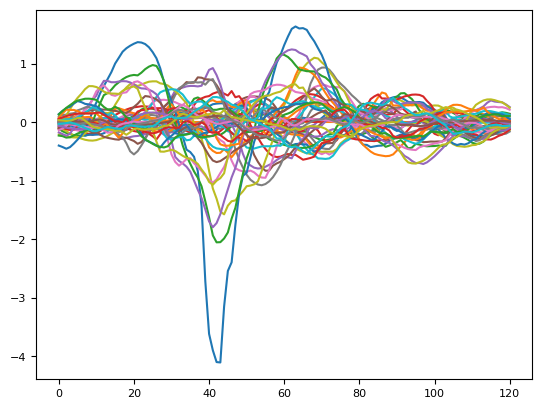

In [7]:
#plot a denoised template on the 40 extracted channels (not all 40 used to train CEED).
template_id = 454
template = templates_sess1[template_id]
max_channel = np.argmax(np.ptp(template,0))
plt.plot(templates_sess1[template_id][:,chan_idx_sess1[max_channel]]);

### Create a couple training datasets

In [8]:
# session 1 units to get data from and dataset save path
# can look at templates of neural units to gauge whether to extract spikes from them for a CEED dataset
selected_units_sess1 = np.arange(400)
dataset_folder_sess1 = save_folder_sess1 + '/ds'

# make a dataset for training
# will create a folder with the spike, probe channel number, and corresponding channel location datasets in the train, val, test splits
# optionally also saves out spatial and temporal noise covariance matrices
inference = False
train_num = 400
val_num = 0
test_num = 100
save_covs = True
num_chans_extract = 21
normalize = False #True for cell-type dataset
shift = False
save_fewer = False
train_set1, val_set1, test_set1, train_geom_locs1, val_geom_locs1, \
test_geom_locs1, train_max_chan1, val_max_chan1, test_max_chan1 = make_dataset(rec=rec1, 
                                                                               spike_index=spike_idx_sess1,
                                                                               geom=geom_sess1, 
                                                                               save_path=dataset_folder_sess1, 
                                                                               chan_index=chan_idx_sess1, 
                                                                               templates=templates_sess1, 
                                                                               unit_ids=selected_units_sess1, 
                                                                               train_num=train_num, 
                                                                               val_num=val_num, 
                                                                               test_num=test_num, 
                                                                               save_covs=save_covs, 
                                                                               num_chans_extract=num_chans_extract, 
                                                                               normalize=normalize, 
                                                                               shift=shift, 
                                                                               inference=inference,
                                                                               save_fewer=save_fewer)

Get Noise Floor
Compute Spatial Covariance
Compute Temporal Covaraince
Starting to search noise snippets...


0it [00:00, ?it/s]

Unit 0 only has 261 spikes, but 500 are requested. Skipping extraction.


3it [00:15,  5.44s/it]

Unit 3 only has 3 spikes, but 500 are requested. Skipping extraction.


10it [00:59,  6.79s/it]

Unit 10 only has 7 spikes, but 500 are requested. Skipping extraction.


12it [01:06,  5.42s/it]

Unit 12 only has 21 spikes, but 500 are requested. Skipping extraction.


14it [01:14,  4.72s/it]

Unit 14 only has 3 spikes, but 500 are requested. Skipping extraction.
Unit 15 only has 148 spikes, but 500 are requested. Skipping extraction.


18it [01:28,  4.24s/it]

Unit 18 only has 131 spikes, but 500 are requested. Skipping extraction.


24it [02:00,  5.35s/it]

Unit 24 only has 283 spikes, but 500 are requested. Skipping extraction.


30it [02:35,  6.08s/it]

Unit 30 only has 28 spikes, but 500 are requested. Skipping extraction.


38it [03:23,  6.62s/it]

Unit 38 only has 10 spikes, but 500 are requested. Skipping extraction.
Unit 39 only has 6 spikes, but 500 are requested. Skipping extraction.


50it [04:19,  5.17s/it]

Unit 50 only has 15 spikes, but 500 are requested. Skipping extraction.


52it [04:25,  4.23s/it]

Unit 52 only has 137 spikes, but 500 are requested. Skipping extraction.


58it [04:55,  4.94s/it]

Unit 58 only has 272 spikes, but 500 are requested. Skipping extraction.
Unit 59 only has 322 spikes, but 500 are requested. Skipping extraction.


62it [05:08,  4.03s/it]

Unit 62 only has 40 spikes, but 500 are requested. Skipping extraction.
Unit 63 only has 195 spikes, but 500 are requested. Skipping extraction.


65it [05:14,  3.17s/it]

Unit 65 only has 28 spikes, but 500 are requested. Skipping extraction.


76it [06:12,  5.55s/it]

Unit 76 only has 9 spikes, but 500 are requested. Skipping extraction.


85it [06:58,  5.52s/it]

Unit 85 only has 3 spikes, but 500 are requested. Skipping extraction.


87it [07:03,  4.10s/it]

Unit 87 only has 1 spikes, but 500 are requested. Skipping extraction.


110it [08:59,  5.46s/it]

Unit 110 only has 182 spikes, but 500 are requested. Skipping extraction.


114it [09:15,  4.68s/it]

Unit 114 only has 27 spikes, but 500 are requested. Skipping extraction.


117it [09:27,  4.29s/it]

Unit 117 only has 55 spikes, but 500 are requested. Skipping extraction.


121it [09:43,  4.36s/it]

Unit 121 only has 290 spikes, but 500 are requested. Skipping extraction.


124it [09:53,  3.98s/it]

Unit 124 only has 270 spikes, but 500 are requested. Skipping extraction.


143it [11:20,  4.50s/it]

Unit 143 only has 398 spikes, but 500 are requested. Skipping extraction.


145it [11:24,  3.35s/it]

Unit 145 only has 91 spikes, but 500 are requested. Skipping extraction.
Unit 146 only has 12 spikes, but 500 are requested. Skipping extraction.


157it [12:15,  4.95s/it]

Unit 157 only has 380 spikes, but 500 are requested. Skipping extraction.


171it [13:16,  4.59s/it]

Unit 171 only has 28 spikes, but 500 are requested. Skipping extraction.


173it [13:20,  3.45s/it]

Unit 173 only has 275 spikes, but 500 are requested. Skipping extraction.
Unit 174 only has 171 spikes, but 500 are requested. Skipping extraction.


193it [14:38,  4.49s/it]

Unit 193 only has 17 spikes, but 500 are requested. Skipping extraction.


196it [14:47,  3.80s/it]

Unit 196 only has 104 spikes, but 500 are requested. Skipping extraction.


199it [14:56,  3.46s/it]

Unit 199 only has 54 spikes, but 500 are requested. Skipping extraction.


209it [15:37,  4.37s/it]

Unit 209 only has 9 spikes, but 500 are requested. Skipping extraction.


221it [16:20,  3.41s/it]

Unit 221 only has 13 spikes, but 500 are requested. Skipping extraction.


223it [16:24,  2.77s/it]

Unit 223 only has 330 spikes, but 500 are requested. Skipping extraction.


226it [16:32,  2.72s/it]

Unit 226 only has 47 spikes, but 500 are requested. Skipping extraction.


228it [16:34,  2.03s/it]

Unit 228 only has 92 spikes, but 500 are requested. Skipping extraction.


233it [16:50,  3.31s/it]

Unit 233 only has 88 spikes, but 500 are requested. Skipping extraction.
Unit 234 only has 382 spikes, but 500 are requested. Skipping extraction.


242it [17:20,  3.78s/it]

Unit 242 only has 20 spikes, but 500 are requested. Skipping extraction.


246it [17:33,  3.47s/it]

Unit 246 only has 69 spikes, but 500 are requested. Skipping extraction.


248it [17:37,  2.92s/it]

Unit 248 only has 85 spikes, but 500 are requested. Skipping extraction.


253it [17:51,  2.96s/it]

Unit 253 only has 133 spikes, but 500 are requested. Skipping extraction.


256it [18:00,  2.92s/it]

Unit 256 only has 336 spikes, but 500 are requested. Skipping extraction.
Unit 257 only has 32 spikes, but 500 are requested. Skipping extraction.


262it [18:10,  2.14s/it]

Unit 262 only has 1 spikes, but 500 are requested. Skipping extraction.
Unit 263 only has 227 spikes, but 500 are requested. Skipping extraction.


267it [18:20,  2.20s/it]

Unit 267 only has 93 spikes, but 500 are requested. Skipping extraction.
Unit 268 only has 353 spikes, but 500 are requested. Skipping extraction.


271it [18:29,  2.27s/it]

Unit 271 only has 217 spikes, but 500 are requested. Skipping extraction.
Unit 272 only has 419 spikes, but 500 are requested. Skipping extraction.


274it [18:33,  1.85s/it]

Unit 274 only has 1 spikes, but 500 are requested. Skipping extraction.


280it [18:52,  2.99s/it]

Unit 280 only has 337 spikes, but 500 are requested. Skipping extraction.


283it [18:58,  2.57s/it]

Unit 283 only has 170 spikes, but 500 are requested. Skipping extraction.


285it [19:01,  2.09s/it]

Unit 285 only has 106 spikes, but 500 are requested. Skipping extraction.
Unit 286 only has 166 spikes, but 500 are requested. Skipping extraction.


291it [19:11,  2.06s/it]

Unit 291 only has 9 spikes, but 500 are requested. Skipping extraction.


293it [19:14,  1.66s/it]

Unit 293 only has 1 spikes, but 500 are requested. Skipping extraction.


297it [19:27,  2.83s/it]

Unit 297 only has 220 spikes, but 500 are requested. Skipping extraction.


299it [19:29,  2.25s/it]

Unit 299 only has 61 spikes, but 500 are requested. Skipping extraction.


301it [19:32,  1.95s/it]

Unit 301 only has 294 spikes, but 500 are requested. Skipping extraction.


306it [19:50,  3.26s/it]

Unit 306 only has 27 spikes, but 500 are requested. Skipping extraction.


312it [20:13,  4.04s/it]

Unit 312 only has 445 spikes, but 500 are requested. Skipping extraction.


315it [20:21,  3.49s/it]

Unit 315 only has 285 spikes, but 500 are requested. Skipping extraction.


317it [20:26,  2.92s/it]

Unit 317 only has 473 spikes, but 500 are requested. Skipping extraction.


327it [21:00,  3.71s/it]

Unit 327 only has 183 spikes, but 500 are requested. Skipping extraction.


340it [21:49,  3.90s/it]

Unit 340 only has 352 spikes, but 500 are requested. Skipping extraction.


344it [22:01,  3.35s/it]

Unit 344 only has 21 spikes, but 500 are requested. Skipping extraction.
Unit 345 only has 4 spikes, but 500 are requested. Skipping extraction.
Unit 346 only has 53 spikes, but 500 are requested. Skipping extraction.


348it [22:05,  1.98s/it]

Unit 348 only has 114 spikes, but 500 are requested. Skipping extraction.


350it [22:09,  2.05s/it]

Unit 350 only has 4 spikes, but 500 are requested. Skipping extraction.


352it [22:14,  2.21s/it]

Unit 352 only has 47 spikes, but 500 are requested. Skipping extraction.


354it [22:19,  2.26s/it]

Unit 354 only has 3 spikes, but 500 are requested. Skipping extraction.


361it [22:47,  3.85s/it]

Unit 361 only has 344 spikes, but 500 are requested. Skipping extraction.


364it [22:52,  2.72s/it]

Unit 364 only has 18 spikes, but 500 are requested. Skipping extraction.


369it [23:09,  3.64s/it]

Unit 369 only has 29 spikes, but 500 are requested. Skipping extraction.
Unit 370 only has 1 spikes, but 500 are requested. Skipping extraction.


374it [23:22,  3.17s/it]

Unit 374 only has 3 spikes, but 500 are requested. Skipping extraction.
Unit 375 only has 123 spikes, but 500 are requested. Skipping extraction.


380it [23:40,  3.39s/it]

Unit 380 only has 81 spikes, but 500 are requested. Skipping extraction.
Unit 381 only has 3 spikes, but 500 are requested. Skipping extraction.


383it [23:42,  2.05s/it]

Unit 383 only has 11 spikes, but 500 are requested. Skipping extraction.


387it [23:53,  2.73s/it]

Unit 387 only has 120 spikes, but 500 are requested. Skipping extraction.
Unit 388 only has 51 spikes, but 500 are requested. Skipping extraction.


390it [23:57,  2.00s/it]

Unit 390 only has 3 spikes, but 500 are requested. Skipping extraction.
Unit 391 only has 30 spikes, but 500 are requested. Skipping extraction.


394it [24:03,  1.85s/it]

Unit 394 only has 120 spikes, but 500 are requested. Skipping extraction.
Unit 395 only has 184 spikes, but 500 are requested. Skipping extraction.


397it [24:08,  1.75s/it]

Unit 397 only has 22 spikes, but 500 are requested. Skipping extraction.


400it [24:12,  3.63s/it]


Unit 399 only has 1 spikes, but 500 are requested. Skipping extraction.
making train, val, test splits
saving split results


In [11]:
# suppose for session 2 we want a larger dataset comprised of most of the units in the recording, 
# but excluding some units that might have poor spikes in the recording or which kilosort did a poor job of recognizing. 
# then we can save out all of the units in the recording to the dataset and plot some spikes from the units (with plot=True)
# and then we can go through and look at which units look like they have good, useful spikes for training. for this we'll
# save out all units at first by specifying no unit ids.
selected_units_sess2 = np.arange(400)
dataset_folder_sess2 = save_folder_sess2 + '/ds'

# make a dataset for training
# will create a folder with the spike, probe channel number, and corresponding channel location datasets in the train, val, test splits
# optionally also saves out spatial and temporal noise covariance matrices
inference = False
train_num = 400
val_num = 0
test_num = 100
save_covs = True
num_chans_extract = 21
normalize = False #True for cell-type dataset
shift = False
save_fewer = False

train_set2, val_set2, test_set2, train_geom_locs, val_geom_locs2, \
test_geom_locs2, train_max_chan2, val_max_chan2, test_max_chan2 = make_dataset(rec=rec2, 
                                                                               spike_index=spike_idx_sess2,
                                                                               geom=geom_sess2, 
                                                                               save_path=dataset_folder_sess2, 
                                                                               chan_index=chan_idx_sess2, 
                                                                               templates=templates_sess2, 
                                                                               unit_ids=selected_units_sess2, 
                                                                               train_num=train_num, 
                                                                               val_num=val_num, 
                                                                               test_num=test_num, 
                                                                               save_covs=save_covs, 
                                                                               num_chans_extract=num_chans_extract, 
                                                                               plot=False,
                                                                               normalize=normalize, 
                                                                               shift=shift, 
                                                                               inference=inference,
                                                                               save_fewer=save_fewer)

Get Noise Floor
Compute Spatial Covariance
Compute Temporal Covaraince
Starting to search noise snippets...


10it [00:56,  5.78s/it]

Unit 10 only has 386 spikes, but 500 are requested. Skipping extraction.
Unit 11 only has 153 spikes, but 500 are requested. Skipping extraction.


18it [01:33,  5.44s/it]

Unit 18 only has 13 spikes, but 500 are requested. Skipping extraction.


20it [01:37,  4.10s/it]

Unit 20 only has 72 spikes, but 500 are requested. Skipping extraction.
Unit 21 only has 113 spikes, but 500 are requested. Skipping extraction.
Unit 22 only has 295 spikes, but 500 are requested. Skipping extraction.
Unit 23 only has 10 spikes, but 500 are requested. Skipping extraction.


25it [01:43,  2.30s/it]

Unit 25 only has 196 spikes, but 500 are requested. Skipping extraction.


27it [01:49,  2.45s/it]

Unit 27 only has 243 spikes, but 500 are requested. Skipping extraction.


32it [02:08,  3.51s/it]

Unit 32 only has 439 spikes, but 500 are requested. Skipping extraction.


37it [02:30,  4.51s/it]

Unit 37 only has 48 spikes, but 500 are requested. Skipping extraction.


44it [02:56,  4.56s/it]

Unit 44 only has 1 spikes, but 500 are requested. Skipping extraction.


53it [03:32,  4.98s/it]

Unit 53 only has 134 spikes, but 500 are requested. Skipping extraction.


55it [03:37,  3.83s/it]

Unit 55 only has 1 spikes, but 500 are requested. Skipping extraction.
Unit 56 only has 1 spikes, but 500 are requested. Skipping extraction.


58it [03:43,  2.91s/it]

Unit 58 only has 153 spikes, but 500 are requested. Skipping extraction.
Unit 59 only has 5 spikes, but 500 are requested. Skipping extraction.


61it [03:46,  2.21s/it]

Unit 61 only has 47 spikes, but 500 are requested. Skipping extraction.


63it [03:50,  2.05s/it]

Unit 63 only has 151 spikes, but 500 are requested. Skipping extraction.
Unit 64 only has 30 spikes, but 500 are requested. Skipping extraction.


67it [03:59,  2.24s/it]

Unit 67 only has 40 spikes, but 500 are requested. Skipping extraction.


70it [04:05,  2.40s/it]

Unit 70 only has 377 spikes, but 500 are requested. Skipping extraction.


73it [04:11,  2.27s/it]

Unit 73 only has 12 spikes, but 500 are requested. Skipping extraction.


75it [04:16,  2.31s/it]

Unit 75 only has 86 spikes, but 500 are requested. Skipping extraction.


79it [04:30,  3.07s/it]

Unit 79 only has 23 spikes, but 500 are requested. Skipping extraction.
Unit 80 only has 60 spikes, but 500 are requested. Skipping extraction.
Unit 81 only has 44 spikes, but 500 are requested. Skipping extraction.


83it [04:33,  1.91s/it]

Unit 83 only has 49 spikes, but 500 are requested. Skipping extraction.


85it [04:36,  1.69s/it]

Unit 85 only has 9 spikes, but 500 are requested. Skipping extraction.


90it [04:56,  3.47s/it]

Unit 90 only has 289 spikes, but 500 are requested. Skipping extraction.


93it [05:04,  3.02s/it]

Unit 93 only has 318 spikes, but 500 are requested. Skipping extraction.


96it [05:13,  3.26s/it]

Unit 96 only has 3 spikes, but 500 are requested. Skipping extraction.
Unit 97 only has 25 spikes, but 500 are requested. Skipping extraction.


99it [05:19,  2.55s/it]

Unit 99 only has 9 spikes, but 500 are requested. Skipping extraction.


101it [05:21,  2.09s/it]

Unit 101 only has 15 spikes, but 500 are requested. Skipping extraction.
Unit 102 only has 1 spikes, but 500 are requested. Skipping extraction.
Unit 103 only has 452 spikes, but 500 are requested. Skipping extraction.


112it [06:00,  4.28s/it]

Unit 112 only has 6 spikes, but 500 are requested. Skipping extraction.


119it [06:27,  4.15s/it]

Unit 119 only has 78 spikes, but 500 are requested. Skipping extraction.


131it [07:15,  4.31s/it]

Unit 131 only has 420 spikes, but 500 are requested. Skipping extraction.


133it [07:20,  3.48s/it]

Unit 133 only has 258 spikes, but 500 are requested. Skipping extraction.


139it [07:40,  3.74s/it]

Unit 139 only has 271 spikes, but 500 are requested. Skipping extraction.
Unit 140 only has 69 spikes, but 500 are requested. Skipping extraction.


142it [07:45,  2.64s/it]

Unit 142 only has 84 spikes, but 500 are requested. Skipping extraction.
Unit 143 only has 11 spikes, but 500 are requested. Skipping extraction.
Unit 144 only has 245 spikes, but 500 are requested. Skipping extraction.
Unit 145 only has 337 spikes, but 500 are requested. Skipping extraction.
Unit 146 only has 260 spikes, but 500 are requested. Skipping extraction.


150it [07:59,  2.42s/it]

Unit 150 only has 24 spikes, but 500 are requested. Skipping extraction.
Unit 151 only has 271 spikes, but 500 are requested. Skipping extraction.
Unit 152 only has 98 spikes, but 500 are requested. Skipping extraction.


155it [08:08,  2.22s/it]

Unit 155 only has 83 spikes, but 500 are requested. Skipping extraction.


158it [08:18,  2.67s/it]

Unit 158 only has 94 spikes, but 500 are requested. Skipping extraction.


163it [08:39,  3.97s/it]

Unit 163 only has 169 spikes, but 500 are requested. Skipping extraction.


167it [08:51,  3.51s/it]

Unit 167 only has 72 spikes, but 500 are requested. Skipping extraction.


169it [08:57,  3.21s/it]

Unit 169 only has 37 spikes, but 500 are requested. Skipping extraction.
Unit 170 only has 477 spikes, but 500 are requested. Skipping extraction.


173it [09:03,  2.46s/it]

Unit 173 only has 69 spikes, but 500 are requested. Skipping extraction.
Unit 174 only has 5 spikes, but 500 are requested. Skipping extraction.


178it [09:16,  2.85s/it]

Unit 178 only has 378 spikes, but 500 are requested. Skipping extraction.


182it [09:29,  3.13s/it]

Unit 182 only has 9 spikes, but 500 are requested. Skipping extraction.
Unit 183 only has 1 spikes, but 500 are requested. Skipping extraction.
Unit 184 only has 497 spikes, but 500 are requested. Skipping extraction.


189it [09:43,  2.73s/it]

Unit 189 only has 16 spikes, but 500 are requested. Skipping extraction.


191it [09:47,  2.54s/it]

Unit 191 only has 207 spikes, but 500 are requested. Skipping extraction.


195it [10:02,  3.49s/it]

Unit 195 only has 21 spikes, but 500 are requested. Skipping extraction.


205it [10:46,  4.94s/it]

Unit 205 only has 106 spikes, but 500 are requested. Skipping extraction.


211it [11:06,  3.56s/it]

Unit 211 only has 4 spikes, but 500 are requested. Skipping extraction.


215it [11:20,  3.75s/it]

Unit 215 only has 438 spikes, but 500 are requested. Skipping extraction.


218it [11:27,  3.21s/it]

Unit 218 only has 157 spikes, but 500 are requested. Skipping extraction.


222it [11:36,  2.74s/it]

Unit 222 only has 270 spikes, but 500 are requested. Skipping extraction.
Unit 223 only has 95 spikes, but 500 are requested. Skipping extraction.
Unit 224 only has 103 spikes, but 500 are requested. Skipping extraction.


231it [12:02,  3.83s/it]

Unit 231 only has 6 spikes, but 500 are requested. Skipping extraction.


235it [12:16,  3.81s/it]

Unit 235 only has 376 spikes, but 500 are requested. Skipping extraction.


239it [12:33,  4.30s/it]

Unit 239 only has 453 spikes, but 500 are requested. Skipping extraction.


250it [13:19,  3.90s/it]

Unit 250 only has 155 spikes, but 500 are requested. Skipping extraction.


260it [13:44,  2.29s/it]

Unit 260 only has 2 spikes, but 500 are requested. Skipping extraction.


263it [13:51,  2.10s/it]

Unit 263 only has 3 spikes, but 500 are requested. Skipping extraction.


265it [13:54,  1.91s/it]

Unit 265 only has 152 spikes, but 500 are requested. Skipping extraction.


267it [13:59,  2.13s/it]

Unit 267 only has 153 spikes, but 500 are requested. Skipping extraction.


270it [14:06,  2.43s/it]

Unit 270 only has 4 spikes, but 500 are requested. Skipping extraction.
Unit 271 only has 53 spikes, but 500 are requested. Skipping extraction.
Unit 272 only has 15 spikes, but 500 are requested. Skipping extraction.


278it [14:31,  3.56s/it]

Unit 278 only has 57 spikes, but 500 are requested. Skipping extraction.


282it [14:45,  3.81s/it]

Unit 282 only has 119 spikes, but 500 are requested. Skipping extraction.


284it [14:49,  3.13s/it]

Unit 284 only has 301 spikes, but 500 are requested. Skipping extraction.


286it [14:55,  3.03s/it]

Unit 286 only has 282 spikes, but 500 are requested. Skipping extraction.


291it [15:12,  3.42s/it]

Unit 291 only has 32 spikes, but 500 are requested. Skipping extraction.
Unit 292 only has 169 spikes, but 500 are requested. Skipping extraction.


295it [15:21,  2.86s/it]

Unit 295 only has 106 spikes, but 500 are requested. Skipping extraction.
Unit 296 only has 320 spikes, but 500 are requested. Skipping extraction.


298it [15:25,  2.22s/it]

Unit 298 only has 207 spikes, but 500 are requested. Skipping extraction.


301it [15:34,  2.62s/it]

Unit 301 only has 28 spikes, but 500 are requested. Skipping extraction.
Unit 302 only has 34 spikes, but 500 are requested. Skipping extraction.


304it [15:39,  2.23s/it]

Unit 304 only has 13 spikes, but 500 are requested. Skipping extraction.
Unit 305 only has 262 spikes, but 500 are requested. Skipping extraction.


311it [16:02,  3.41s/it]

Unit 311 only has 2 spikes, but 500 are requested. Skipping extraction.


313it [16:04,  2.58s/it]

Unit 313 only has 55 spikes, but 500 are requested. Skipping extraction.


329it [17:16,  5.09s/it]

Unit 329 only has 372 spikes, but 500 are requested. Skipping extraction.
Unit 330 only has 45 spikes, but 500 are requested. Skipping extraction.
Unit 331 only has 18 spikes, but 500 are requested. Skipping extraction.


335it [17:25,  2.56s/it]

Unit 335 only has 311 spikes, but 500 are requested. Skipping extraction.


340it [17:44,  3.73s/it]

Unit 340 only has 196 spikes, but 500 are requested. Skipping extraction.


343it [17:53,  3.36s/it]

Unit 343 only has 101 spikes, but 500 are requested. Skipping extraction.


347it [18:07,  3.81s/it]

Unit 347 only has 148 spikes, but 500 are requested. Skipping extraction.
Unit 348 only has 8 spikes, but 500 are requested. Skipping extraction.
Unit 349 only has 179 spikes, but 500 are requested. Skipping extraction.


355it [18:28,  3.05s/it]

Unit 355 only has 89 spikes, but 500 are requested. Skipping extraction.
Unit 356 only has 494 spikes, but 500 are requested. Skipping extraction.


358it [18:33,  2.25s/it]

Unit 358 only has 204 spikes, but 500 are requested. Skipping extraction.


360it [18:38,  2.37s/it]

Unit 360 only has 1 spikes, but 500 are requested. Skipping extraction.
Unit 361 only has 1 spikes, but 500 are requested. Skipping extraction.
Unit 362 only has 37 spikes, but 500 are requested. Skipping extraction.
Unit 363 only has 12 spikes, but 500 are requested. Skipping extraction.
Unit 364 only has 139 spikes, but 500 are requested. Skipping extraction.
Unit 365 only has 3 spikes, but 500 are requested. Skipping extraction.
Unit 366 only has 140 spikes, but 500 are requested. Skipping extraction.
Unit 367 only has 174 spikes, but 500 are requested. Skipping extraction.
Unit 368 only has 19 spikes, but 500 are requested. Skipping extraction.
Unit 369 only has 3 spikes, but 500 are requested. Skipping extraction.


372it [18:49,  1.38s/it]

Unit 372 only has 15 spikes, but 500 are requested. Skipping extraction.
Unit 373 only has 334 spikes, but 500 are requested. Skipping extraction.
Unit 374 only has 102 spikes, but 500 are requested. Skipping extraction.
Unit 375 only has 15 spikes, but 500 are requested. Skipping extraction.
Unit 376 only has 5 spikes, but 500 are requested. Skipping extraction.
Unit 377 only has 38 spikes, but 500 are requested. Skipping extraction.
Unit 378 only has 63 spikes, but 500 are requested. Skipping extraction.
Unit 379 only has 105 spikes, but 500 are requested. Skipping extraction.
Unit 380 only has 1 spikes, but 500 are requested. Skipping extraction.
Unit 381 only has 266 spikes, but 500 are requested. Skipping extraction.


383it [18:51,  1.40it/s]

Unit 383 only has 160 spikes, but 500 are requested. Skipping extraction.


385it [18:55,  1.16it/s]

Unit 385 only has 36 spikes, but 500 are requested. Skipping extraction.


389it [19:05,  1.41s/it]

Unit 389 only has 345 spikes, but 500 are requested. Skipping extraction.


392it [19:15,  2.21s/it]

Unit 392 only has 3 spikes, but 500 are requested. Skipping extraction.
Unit 393 only has 465 spikes, but 500 are requested. Skipping extraction.
Unit 394 only has 49 spikes, but 500 are requested. Skipping extraction.
Unit 395 only has 26 spikes, but 500 are requested. Skipping extraction.


400it [19:24,  2.91s/it]


Unit 398 only has 448 spikes, but 500 are requested. Skipping extraction.
Unit 399 only has 61 spikes, but 500 are requested. Skipping extraction.
making train, val, test splits
saving split results


In [12]:
# after looking at all of the plotted units in session 2's dataset folder (under wf_plots) we decide to exclude certain units.
# we can also decide to make selected_units_sess2 out of the units we decide are good rather than exclude units 
# if we find too many bad units (we would just define it as a list of units in this latter case).
bad_units_sess2 = [130, 250, 340]
selected_units_sess2 = all_units_except(spike_index=spike_idx_sess2, exclude_units=bad_units_sess2)

# now we can create the same dataset, but overwrite the previous files with the new ones that exclude the unit ids we don't want
train_set2, val_set2, test_set2, train_geom_locs, val_geom_locs2, \
test_geom_locs2, train_max_chan2, val_max_chan2, test_max_chan2 = make_dataset(rec=rec2, 
                                                                               spike_index=spike_idx_sess2,
                                                                               geom=geom_sess2, 
                                                                               save_path=dataset_folder_sess2, 
                                                                               chan_index=chan_idx_sess2, 
                                                                               templates=templates_sess2, 
                                                                               unit_ids=selected_units_sess2, 
                                                                               train_num=train_num, 
                                                                               val_num=val_num, 
                                                                               test_num=test_num, 
                                                                               save_covs=save_covs, 
                                                                               num_chans_extract=num_chans_extract, 
                                                                               plot=False,
                                                                               normalize=normalize, 
                                                                               shift=shift, 
                                                                               inference=inference,
                                                                               save_fewer=save_fewer)

Get Noise Floor
Compute Spatial Covariance
Compute Temporal Covaraince
Starting to search noise snippets...


10it [00:55,  5.21s/it]

Unit 10 only has 386 spikes, but 500 are requested. Skipping extraction.
Unit 11 only has 153 spikes, but 500 are requested. Skipping extraction.


18it [01:27,  4.73s/it]

Unit 18 only has 13 spikes, but 500 are requested. Skipping extraction.


20it [01:32,  3.86s/it]

Unit 20 only has 72 spikes, but 500 are requested. Skipping extraction.
Unit 21 only has 113 spikes, but 500 are requested. Skipping extraction.
Unit 22 only has 295 spikes, but 500 are requested. Skipping extraction.
Unit 23 only has 10 spikes, but 500 are requested. Skipping extraction.


25it [01:37,  2.09s/it]

Unit 25 only has 196 spikes, but 500 are requested. Skipping extraction.


27it [01:42,  2.21s/it]

Unit 27 only has 243 spikes, but 500 are requested. Skipping extraction.


32it [02:01,  3.42s/it]

Unit 32 only has 439 spikes, but 500 are requested. Skipping extraction.


37it [02:22,  4.16s/it]

Unit 37 only has 48 spikes, but 500 are requested. Skipping extraction.


44it [02:48,  4.25s/it]

Unit 44 only has 1 spikes, but 500 are requested. Skipping extraction.


53it [03:23,  4.53s/it]

Unit 53 only has 134 spikes, but 500 are requested. Skipping extraction.


55it [03:27,  3.48s/it]

Unit 55 only has 1 spikes, but 500 are requested. Skipping extraction.
Unit 56 only has 1 spikes, but 500 are requested. Skipping extraction.


58it [03:32,  2.57s/it]

Unit 58 only has 153 spikes, but 500 are requested. Skipping extraction.
Unit 59 only has 5 spikes, but 500 are requested. Skipping extraction.


61it [03:37,  2.13s/it]

Unit 61 only has 47 spikes, but 500 are requested. Skipping extraction.


63it [03:41,  2.09s/it]

Unit 63 only has 151 spikes, but 500 are requested. Skipping extraction.
Unit 64 only has 30 spikes, but 500 are requested. Skipping extraction.


67it [03:50,  2.38s/it]

Unit 67 only has 40 spikes, but 500 are requested. Skipping extraction.


70it [03:58,  2.64s/it]

Unit 70 only has 377 spikes, but 500 are requested. Skipping extraction.


73it [04:06,  2.66s/it]

Unit 73 only has 12 spikes, but 500 are requested. Skipping extraction.


75it [04:11,  2.53s/it]

Unit 75 only has 86 spikes, but 500 are requested. Skipping extraction.


79it [04:26,  3.44s/it]

Unit 79 only has 23 spikes, but 500 are requested. Skipping extraction.
Unit 80 only has 60 spikes, but 500 are requested. Skipping extraction.
Unit 81 only has 44 spikes, but 500 are requested. Skipping extraction.


83it [04:31,  2.25s/it]

Unit 83 only has 49 spikes, but 500 are requested. Skipping extraction.


85it [04:35,  2.16s/it]

Unit 85 only has 9 spikes, but 500 are requested. Skipping extraction.


90it [04:54,  3.54s/it]

Unit 90 only has 289 spikes, but 500 are requested. Skipping extraction.


93it [05:03,  3.40s/it]

Unit 93 only has 318 spikes, but 500 are requested. Skipping extraction.


96it [05:14,  3.51s/it]

Unit 96 only has 3 spikes, but 500 are requested. Skipping extraction.
Unit 97 only has 25 spikes, but 500 are requested. Skipping extraction.


99it [05:19,  2.68s/it]

Unit 99 only has 9 spikes, but 500 are requested. Skipping extraction.


101it [05:22,  2.31s/it]

Unit 101 only has 15 spikes, but 500 are requested. Skipping extraction.
Unit 102 only has 1 spikes, but 500 are requested. Skipping extraction.
Unit 103 only has 452 spikes, but 500 are requested. Skipping extraction.


112it [06:01,  4.25s/it]

Unit 112 only has 6 spikes, but 500 are requested. Skipping extraction.


119it [06:28,  4.34s/it]

Unit 119 only has 78 spikes, but 500 are requested. Skipping extraction.


130it [07:15,  4.74s/it]

Unit 131 only has 420 spikes, but 500 are requested. Skipping extraction.


132it [07:20,  3.85s/it]

Unit 133 only has 258 spikes, but 500 are requested. Skipping extraction.


138it [07:43,  4.30s/it]

Unit 139 only has 271 spikes, but 500 are requested. Skipping extraction.
Unit 140 only has 69 spikes, but 500 are requested. Skipping extraction.


141it [07:49,  3.01s/it]

Unit 142 only has 84 spikes, but 500 are requested. Skipping extraction.
Unit 143 only has 11 spikes, but 500 are requested. Skipping extraction.
Unit 144 only has 245 spikes, but 500 are requested. Skipping extraction.
Unit 145 only has 337 spikes, but 500 are requested. Skipping extraction.
Unit 146 only has 260 spikes, but 500 are requested. Skipping extraction.


149it [08:05,  2.69s/it]

Unit 150 only has 24 spikes, but 500 are requested. Skipping extraction.
Unit 151 only has 271 spikes, but 500 are requested. Skipping extraction.
Unit 152 only has 98 spikes, but 500 are requested. Skipping extraction.


154it [08:15,  2.51s/it]

Unit 155 only has 83 spikes, but 500 are requested. Skipping extraction.


157it [08:26,  3.00s/it]

Unit 158 only has 94 spikes, but 500 are requested. Skipping extraction.


162it [08:48,  4.35s/it]

Unit 163 only has 169 spikes, but 500 are requested. Skipping extraction.


166it [09:02,  3.93s/it]

Unit 167 only has 72 spikes, but 500 are requested. Skipping extraction.


168it [09:08,  3.48s/it]

Unit 169 only has 37 spikes, but 500 are requested. Skipping extraction.
Unit 170 only has 477 spikes, but 500 are requested. Skipping extraction.


172it [09:15,  2.72s/it]

Unit 173 only has 69 spikes, but 500 are requested. Skipping extraction.
Unit 174 only has 5 spikes, but 500 are requested. Skipping extraction.


177it [09:29,  3.15s/it]

Unit 178 only has 378 spikes, but 500 are requested. Skipping extraction.


181it [09:43,  3.39s/it]

Unit 182 only has 9 spikes, but 500 are requested. Skipping extraction.
Unit 183 only has 1 spikes, but 500 are requested. Skipping extraction.
Unit 184 only has 497 spikes, but 500 are requested. Skipping extraction.


188it [09:58,  2.91s/it]

Unit 189 only has 16 spikes, but 500 are requested. Skipping extraction.


190it [10:02,  2.63s/it]

Unit 191 only has 207 spikes, but 500 are requested. Skipping extraction.


194it [10:18,  3.58s/it]

Unit 195 only has 21 spikes, but 500 are requested. Skipping extraction.


204it [11:02,  4.91s/it]

Unit 205 only has 106 spikes, but 500 are requested. Skipping extraction.


210it [11:22,  3.61s/it]

Unit 211 only has 4 spikes, but 500 are requested. Skipping extraction.


214it [11:35,  3.51s/it]

Unit 215 only has 438 spikes, but 500 are requested. Skipping extraction.


217it [11:42,  2.92s/it]

Unit 218 only has 157 spikes, but 500 are requested. Skipping extraction.


221it [11:49,  2.55s/it]

Unit 222 only has 270 spikes, but 500 are requested. Skipping extraction.
Unit 223 only has 95 spikes, but 500 are requested. Skipping extraction.
Unit 224 only has 103 spikes, but 500 are requested. Skipping extraction.


230it [12:14,  3.58s/it]

Unit 231 only has 6 spikes, but 500 are requested. Skipping extraction.


234it [12:27,  3.57s/it]

Unit 235 only has 376 spikes, but 500 are requested. Skipping extraction.


238it [12:43,  3.96s/it]

Unit 239 only has 453 spikes, but 500 are requested. Skipping extraction.


258it [13:48,  2.14s/it]

Unit 260 only has 2 spikes, but 500 are requested. Skipping extraction.


261it [13:53,  1.94s/it]

Unit 263 only has 3 spikes, but 500 are requested. Skipping extraction.


263it [13:56,  1.76s/it]

Unit 265 only has 152 spikes, but 500 are requested. Skipping extraction.


265it [14:00,  1.89s/it]

Unit 267 only has 153 spikes, but 500 are requested. Skipping extraction.


268it [14:07,  2.17s/it]

Unit 270 only has 4 spikes, but 500 are requested. Skipping extraction.
Unit 271 only has 53 spikes, but 500 are requested. Skipping extraction.
Unit 272 only has 15 spikes, but 500 are requested. Skipping extraction.


276it [14:27,  2.99s/it]

Unit 278 only has 57 spikes, but 500 are requested. Skipping extraction.


280it [14:40,  3.25s/it]

Unit 282 only has 119 spikes, but 500 are requested. Skipping extraction.


282it [14:43,  2.63s/it]

Unit 284 only has 301 spikes, but 500 are requested. Skipping extraction.


284it [14:48,  2.56s/it]

Unit 286 only has 282 spikes, but 500 are requested. Skipping extraction.


289it [15:02,  2.91s/it]

Unit 291 only has 32 spikes, but 500 are requested. Skipping extraction.
Unit 292 only has 169 spikes, but 500 are requested. Skipping extraction.


293it [15:10,  2.43s/it]

Unit 295 only has 106 spikes, but 500 are requested. Skipping extraction.
Unit 296 only has 320 spikes, but 500 are requested. Skipping extraction.


296it [15:13,  1.83s/it]

Unit 298 only has 207 spikes, but 500 are requested. Skipping extraction.


299it [15:21,  2.20s/it]

Unit 301 only has 28 spikes, but 500 are requested. Skipping extraction.
Unit 302 only has 34 spikes, but 500 are requested. Skipping extraction.


302it [15:25,  1.89s/it]

Unit 304 only has 13 spikes, but 500 are requested. Skipping extraction.
Unit 305 only has 262 spikes, but 500 are requested. Skipping extraction.


309it [15:44,  2.86s/it]

Unit 311 only has 2 spikes, but 500 are requested. Skipping extraction.


311it [15:46,  2.19s/it]

Unit 313 only has 55 spikes, but 500 are requested. Skipping extraction.


327it [16:44,  4.04s/it]

Unit 329 only has 372 spikes, but 500 are requested. Skipping extraction.
Unit 330 only has 45 spikes, but 500 are requested. Skipping extraction.
Unit 331 only has 18 spikes, but 500 are requested. Skipping extraction.


333it [16:52,  2.09s/it]

Unit 335 only has 311 spikes, but 500 are requested. Skipping extraction.


340it [17:12,  2.97s/it]

Unit 343 only has 101 spikes, but 500 are requested. Skipping extraction.


344it [17:22,  2.85s/it]

Unit 347 only has 148 spikes, but 500 are requested. Skipping extraction.
Unit 348 only has 8 spikes, but 500 are requested. Skipping extraction.
Unit 349 only has 179 spikes, but 500 are requested. Skipping extraction.


352it [17:37,  2.25s/it]

Unit 355 only has 89 spikes, but 500 are requested. Skipping extraction.
Unit 356 only has 494 spikes, but 500 are requested. Skipping extraction.


355it [17:40,  1.58s/it]

Unit 358 only has 204 spikes, but 500 are requested. Skipping extraction.


357it [17:44,  1.66s/it]

Unit 360 only has 1 spikes, but 500 are requested. Skipping extraction.
Unit 361 only has 1 spikes, but 500 are requested. Skipping extraction.
Unit 362 only has 37 spikes, but 500 are requested. Skipping extraction.
Unit 363 only has 12 spikes, but 500 are requested. Skipping extraction.
Unit 364 only has 139 spikes, but 500 are requested. Skipping extraction.
Unit 365 only has 3 spikes, but 500 are requested. Skipping extraction.
Unit 366 only has 140 spikes, but 500 are requested. Skipping extraction.
Unit 367 only has 174 spikes, but 500 are requested. Skipping extraction.
Unit 368 only has 19 spikes, but 500 are requested. Skipping extraction.
Unit 369 only has 3 spikes, but 500 are requested. Skipping extraction.


369it [17:51,  1.03it/s]

Unit 372 only has 15 spikes, but 500 are requested. Skipping extraction.
Unit 373 only has 334 spikes, but 500 are requested. Skipping extraction.
Unit 374 only has 102 spikes, but 500 are requested. Skipping extraction.
Unit 375 only has 15 spikes, but 500 are requested. Skipping extraction.
Unit 376 only has 5 spikes, but 500 are requested. Skipping extraction.
Unit 377 only has 38 spikes, but 500 are requested. Skipping extraction.
Unit 378 only has 63 spikes, but 500 are requested. Skipping extraction.
Unit 379 only has 105 spikes, but 500 are requested. Skipping extraction.
Unit 380 only has 1 spikes, but 500 are requested. Skipping extraction.
Unit 381 only has 266 spikes, but 500 are requested. Skipping extraction.


380it [17:53,  1.91it/s]

Unit 383 only has 160 spikes, but 500 are requested. Skipping extraction.


382it [17:56,  1.56it/s]

Unit 385 only has 36 spikes, but 500 are requested. Skipping extraction.


386it [18:03,  1.06s/it]

Unit 389 only has 345 spikes, but 500 are requested. Skipping extraction.


389it [18:10,  1.56s/it]

Unit 392 only has 3 spikes, but 500 are requested. Skipping extraction.
Unit 393 only has 465 spikes, but 500 are requested. Skipping extraction.
Unit 394 only has 49 spikes, but 500 are requested. Skipping extraction.
Unit 395 only has 26 spikes, but 500 are requested. Skipping extraction.


395it [18:17,  1.36s/it]

Unit 398 only has 448 spikes, but 500 are requested. Skipping extraction.
Unit 399 only has 61 spikes, but 500 are requested. Skipping extraction.


398it [18:20,  1.33s/it]

Unit 401 only has 76 spikes, but 500 are requested. Skipping extraction.
Unit 402 only has 56 spikes, but 500 are requested. Skipping extraction.
Unit 403 only has 22 spikes, but 500 are requested. Skipping extraction.


407it [18:40,  2.49s/it]

Unit 410 only has 40 spikes, but 500 are requested. Skipping extraction.


409it [18:41,  1.88s/it]

Unit 412 only has 225 spikes, but 500 are requested. Skipping extraction.
Unit 413 only has 101 spikes, but 500 are requested. Skipping extraction.


414it [18:51,  2.13s/it]

Unit 417 only has 204 spikes, but 500 are requested. Skipping extraction.


416it [18:55,  2.05s/it]

Unit 419 only has 245 spikes, but 500 are requested. Skipping extraction.
Unit 420 only has 3 spikes, but 500 are requested. Skipping extraction.
Unit 421 only has 84 spikes, but 500 are requested. Skipping extraction.
Unit 422 only has 93 spikes, but 500 are requested. Skipping extraction.


421it [19:00,  1.38s/it]

Unit 424 only has 13 spikes, but 500 are requested. Skipping extraction.
Unit 425 only has 316 spikes, but 500 are requested. Skipping extraction.
Unit 426 only has 61 spikes, but 500 are requested. Skipping extraction.
Unit 427 only has 42 spikes, but 500 are requested. Skipping extraction.


426it [19:04,  1.11s/it]

Unit 429 only has 6 spikes, but 500 are requested. Skipping extraction.


429it [19:10,  1.39s/it]

Unit 432 only has 203 spikes, but 500 are requested. Skipping extraction.


431it [19:14,  1.57s/it]

Unit 434 only has 123 spikes, but 500 are requested. Skipping extraction.
Unit 435 only has 42 spikes, but 500 are requested. Skipping extraction.


434it [19:17,  1.32s/it]

Unit 437 only has 160 spikes, but 500 are requested. Skipping extraction.
Unit 438 only has 57 spikes, but 500 are requested. Skipping extraction.
Unit 439 only has 16 spikes, but 500 are requested. Skipping extraction.
Unit 440 only has 204 spikes, but 500 are requested. Skipping extraction.
Unit 441 only has 82 spikes, but 500 are requested. Skipping extraction.
Unit 442 only has 3 spikes, but 500 are requested. Skipping extraction.
Unit 443 only has 485 spikes, but 500 are requested. Skipping extraction.
Unit 444 only has 443 spikes, but 500 are requested. Skipping extraction.
Unit 445 only has 5 spikes, but 500 are requested. Skipping extraction.
Unit 446 only has 1 spikes, but 500 are requested. Skipping extraction.


445it [19:20,  1.47it/s]

Unit 448 only has 480 spikes, but 500 are requested. Skipping extraction.
Unit 449 only has 210 spikes, but 500 are requested. Skipping extraction.
Unit 450 only has 57 spikes, but 500 are requested. Skipping extraction.


454it [19:25,  2.57s/it]


Unit 452 only has 149 spikes, but 500 are requested. Skipping extraction.
Unit 453 only has 55 spikes, but 500 are requested. Skipping extraction.
Unit 454 only has 2 spikes, but 500 are requested. Skipping extraction.
Unit 455 only has 76 spikes, but 500 are requested. Skipping extraction.
Unit 456 only has 174 spikes, but 500 are requested. Skipping extraction.
making train, val, test splits
saving split results


### Combine the datasets

In [13]:
combined_ds_path = save_dir + 'combined_dataset/'

# combine the two training datasets into a larger one for more unit diversity
dataset_list = [dataset_folder_sess1, dataset_folder_sess2]
combine_datasets(dataset_list, combined_ds_path)

### Make an inference dataset

In [14]:
# session 1 units to get data from and dataset save path
selected_units_inference = np.arange(400)
inference_ds_path = save_folder_sess1 + '/ds_inference'

# make a dataset for inference (testing)
# will create a folder with the spike, probe channel number, and corresponding channel location datasets in the train, val, test splits
# optionally also saves out spatial and temporal noise covariance matrices
inference = True
test_num = 500
save_covs = True
num_chans_extract = 21
normalize = False
shift = False

test_set, test_geom_locs, test_max_chan = make_dataset(rec=rec1, 
                                                       spike_index=spike_idx_sess1,
                                                       geom=geom_sess1, 
                                                       save_path=inference_ds_path, 
                                                       chan_index=chan_idx_sess1, 
                                                       templates=templates_sess1, 
                                                       unit_ids=selected_units_inference, 
                                                       train_num=train_num, 
                                                       val_num=val_num, 
                                                       test_num=test_num, 
                                                       save_covs=save_covs, 
                                                       num_chans_extract=num_chans_extract, 
                                                       normalize=normalize, 
                                                       shift=shift, 
                                                       inference=inference,
                                                       save_fewer=save_fewer)

0it [00:00, ?it/s]

Unit 0 only has 261 spikes, but 900 are requested. Skipping extraction.


3it [00:43, 15.29s/it]

Unit 3 only has 3 spikes, but 900 are requested. Skipping extraction.


7it [01:32, 13.35s/it]

Unit 7 only has 740 spikes, but 900 are requested. Skipping extraction.


10it [01:55, 10.33s/it]

Unit 10 only has 7 spikes, but 900 are requested. Skipping extraction.


12it [02:07,  8.60s/it]

Unit 12 only has 21 spikes, but 900 are requested. Skipping extraction.


14it [02:19,  7.61s/it]

Unit 14 only has 3 spikes, but 900 are requested. Skipping extraction.
Unit 15 only has 148 spikes, but 900 are requested. Skipping extraction.


18it [02:38,  6.31s/it]

Unit 18 only has 131 spikes, but 900 are requested. Skipping extraction.


24it [03:19,  6.98s/it]

Unit 24 only has 283 spikes, but 900 are requested. Skipping extraction.


30it [04:13,  9.32s/it]

Unit 30 only has 28 spikes, but 900 are requested. Skipping extraction.


38it [05:28, 10.18s/it]

Unit 38 only has 10 spikes, but 900 are requested. Skipping extraction.
Unit 39 only has 6 spikes, but 900 are requested. Skipping extraction.


41it [05:39,  6.50s/it]

Unit 41 only has 684 spikes, but 900 are requested. Skipping extraction.


46it [06:17,  7.78s/it]

Unit 46 only has 812 spikes, but 900 are requested. Skipping extraction.


49it [06:36,  7.22s/it]

Unit 49 only has 803 spikes, but 900 are requested. Skipping extraction.
Unit 50 only has 15 spikes, but 900 are requested. Skipping extraction.


52it [06:45,  5.20s/it]

Unit 52 only has 137 spikes, but 900 are requested. Skipping extraction.


58it [07:28,  6.74s/it]

Unit 58 only has 272 spikes, but 900 are requested. Skipping extraction.
Unit 59 only has 322 spikes, but 900 are requested. Skipping extraction.


62it [07:48,  5.84s/it]

Unit 62 only has 40 spikes, but 900 are requested. Skipping extraction.
Unit 63 only has 195 spikes, but 900 are requested. Skipping extraction.


65it [07:58,  4.67s/it]

Unit 65 only has 28 spikes, but 900 are requested. Skipping extraction.


76it [09:33,  9.24s/it]

Unit 76 only has 9 spikes, but 900 are requested. Skipping extraction.


85it [10:46,  8.61s/it]

Unit 85 only has 3 spikes, but 900 are requested. Skipping extraction.


87it [10:54,  6.49s/it]

Unit 87 only has 1 spikes, but 900 are requested. Skipping extraction.


92it [11:31,  7.67s/it]

Unit 92 only has 724 spikes, but 900 are requested. Skipping extraction.


110it [14:10,  9.46s/it]

Unit 110 only has 182 spikes, but 900 are requested. Skipping extraction.


114it [14:36,  7.59s/it]

Unit 114 only has 27 spikes, but 900 are requested. Skipping extraction.


117it [14:55,  7.20s/it]

Unit 117 only has 55 spikes, but 900 are requested. Skipping extraction.


121it [15:25,  7.69s/it]

Unit 121 only has 290 spikes, but 900 are requested. Skipping extraction.


124it [15:44,  7.21s/it]

Unit 124 only has 270 spikes, but 900 are requested. Skipping extraction.


140it [17:57,  8.90s/it]

Unit 140 only has 731 spikes, but 900 are requested. Skipping extraction.


143it [18:13,  6.95s/it]

Unit 143 only has 398 spikes, but 900 are requested. Skipping extraction.


145it [18:18,  5.23s/it]

Unit 145 only has 91 spikes, but 900 are requested. Skipping extraction.
Unit 146 only has 12 spikes, but 900 are requested. Skipping extraction.


157it [19:54,  9.11s/it]

Unit 157 only has 380 spikes, but 900 are requested. Skipping extraction.


171it [21:47,  8.57s/it]

Unit 171 only has 28 spikes, but 900 are requested. Skipping extraction.


173it [21:55,  6.48s/it]

Unit 173 only has 275 spikes, but 900 are requested. Skipping extraction.
Unit 174 only has 171 spikes, but 900 are requested. Skipping extraction.
Unit 175 only has 524 spikes, but 900 are requested. Skipping extraction.


180it [22:32,  6.51s/it]

Unit 180 only has 813 spikes, but 900 are requested. Skipping extraction.


187it [23:28,  8.43s/it]

Unit 187 only has 662 spikes, but 900 are requested. Skipping extraction.


193it [24:14,  8.40s/it]

Unit 193 only has 17 spikes, but 900 are requested. Skipping extraction.


196it [24:32,  7.27s/it]

Unit 196 only has 104 spikes, but 900 are requested. Skipping extraction.


199it [24:49,  6.69s/it]

Unit 199 only has 54 spikes, but 900 are requested. Skipping extraction.


209it [26:07,  8.49s/it]

Unit 209 only has 9 spikes, but 900 are requested. Skipping extraction.


216it [26:54,  7.69s/it]

Unit 216 only has 506 spikes, but 900 are requested. Skipping extraction.


220it [27:20,  7.26s/it]

Unit 220 only has 534 spikes, but 900 are requested. Skipping extraction.
Unit 221 only has 13 spikes, but 900 are requested. Skipping extraction.


223it [27:26,  4.55s/it]

Unit 223 only has 330 spikes, but 900 are requested. Skipping extraction.


226it [27:42,  4.99s/it]

Unit 226 only has 47 spikes, but 900 are requested. Skipping extraction.
Unit 227 only has 523 spikes, but 900 are requested. Skipping extraction.
Unit 228 only has 92 spikes, but 900 are requested. Skipping extraction.


233it [28:13,  5.55s/it]

Unit 233 only has 88 spikes, but 900 are requested. Skipping extraction.
Unit 234 only has 382 spikes, but 900 are requested. Skipping extraction.


242it [29:10,  7.23s/it]

Unit 242 only has 20 spikes, but 900 are requested. Skipping extraction.


246it [29:33,  6.58s/it]

Unit 246 only has 69 spikes, but 900 are requested. Skipping extraction.


248it [29:42,  5.58s/it]

Unit 248 only has 85 spikes, but 900 are requested. Skipping extraction.


252it [30:02,  5.59s/it]

Unit 252 only has 802 spikes, but 900 are requested. Skipping extraction.
Unit 253 only has 133 spikes, but 900 are requested. Skipping extraction.


256it [30:16,  4.44s/it]

Unit 256 only has 336 spikes, but 900 are requested. Skipping extraction.
Unit 257 only has 32 spikes, but 900 are requested. Skipping extraction.


260it [30:28,  4.01s/it]

Unit 260 only has 821 spikes, but 900 are requested. Skipping extraction.
Unit 261 only has 717 spikes, but 900 are requested. Skipping extraction.
Unit 262 only has 1 spikes, but 900 are requested. Skipping extraction.
Unit 263 only has 227 spikes, but 900 are requested. Skipping extraction.


265it [30:36,  2.70s/it]

Unit 265 only has 577 spikes, but 900 are requested. Skipping extraction.


267it [30:44,  2.92s/it]

Unit 267 only has 93 spikes, but 900 are requested. Skipping extraction.
Unit 268 only has 353 spikes, but 900 are requested. Skipping extraction.


271it [31:00,  3.63s/it]

Unit 271 only has 217 spikes, but 900 are requested. Skipping extraction.
Unit 272 only has 419 spikes, but 900 are requested. Skipping extraction.


274it [31:07,  3.19s/it]

Unit 274 only has 1 spikes, but 900 are requested. Skipping extraction.


280it [31:43,  5.28s/it]

Unit 280 only has 337 spikes, but 900 are requested. Skipping extraction.


283it [31:56,  4.90s/it]

Unit 283 only has 170 spikes, but 900 are requested. Skipping extraction.


285it [32:02,  4.10s/it]

Unit 285 only has 106 spikes, but 900 are requested. Skipping extraction.
Unit 286 only has 166 spikes, but 900 are requested. Skipping extraction.


288it [32:08,  3.13s/it]

Unit 288 only has 601 spikes, but 900 are requested. Skipping extraction.


291it [32:19,  3.47s/it]

Unit 291 only has 9 spikes, but 900 are requested. Skipping extraction.
Unit 292 only has 660 spikes, but 900 are requested. Skipping extraction.
Unit 293 only has 1 spikes, but 900 are requested. Skipping extraction.


297it [32:42,  4.22s/it]

Unit 297 only has 220 spikes, but 900 are requested. Skipping extraction.
Unit 298 only has 818 spikes, but 900 are requested. Skipping extraction.
Unit 299 only has 61 spikes, but 900 are requested. Skipping extraction.


301it [32:46,  2.68s/it]

Unit 301 only has 294 spikes, but 900 are requested. Skipping extraction.


306it [33:15,  4.72s/it]

Unit 306 only has 27 spikes, but 900 are requested. Skipping extraction.


312it [33:55,  6.76s/it]

Unit 312 only has 445 spikes, but 900 are requested. Skipping extraction.


315it [34:10,  5.97s/it]

Unit 315 only has 285 spikes, but 900 are requested. Skipping extraction.


317it [34:17,  4.97s/it]

Unit 317 only has 473 spikes, but 900 are requested. Skipping extraction.


319it [34:23,  4.37s/it]

Unit 319 only has 894 spikes, but 900 are requested. Skipping extraction.


327it [35:11,  6.12s/it]

Unit 327 only has 183 spikes, but 900 are requested. Skipping extraction.


338it [36:16,  6.21s/it]

Unit 338 only has 675 spikes, but 900 are requested. Skipping extraction.


340it [36:23,  4.98s/it]

Unit 340 only has 352 spikes, but 900 are requested. Skipping extraction.


344it [36:42,  5.00s/it]

Unit 344 only has 21 spikes, but 900 are requested. Skipping extraction.
Unit 345 only has 4 spikes, but 900 are requested. Skipping extraction.
Unit 346 only has 53 spikes, but 900 are requested. Skipping extraction.


348it [36:47,  2.84s/it]

Unit 348 only has 114 spikes, but 900 are requested. Skipping extraction.


350it [36:55,  3.11s/it]

Unit 350 only has 4 spikes, but 900 are requested. Skipping extraction.


352it [37:02,  3.26s/it]

Unit 352 only has 47 spikes, but 900 are requested. Skipping extraction.


354it [37:09,  3.34s/it]

Unit 354 only has 3 spikes, but 900 are requested. Skipping extraction.


361it [37:51,  5.85s/it]

Unit 361 only has 344 spikes, but 900 are requested. Skipping extraction.


363it [37:57,  4.66s/it]

Unit 363 only has 751 spikes, but 900 are requested. Skipping extraction.
Unit 364 only has 18 spikes, but 900 are requested. Skipping extraction.
Unit 365 only has 599 spikes, but 900 are requested. Skipping extraction.


369it [38:19,  4.50s/it]

Unit 369 only has 29 spikes, but 900 are requested. Skipping extraction.
Unit 370 only has 1 spikes, but 900 are requested. Skipping extraction.


374it [38:37,  4.22s/it]

Unit 374 only has 3 spikes, but 900 are requested. Skipping extraction.
Unit 375 only has 123 spikes, but 900 are requested. Skipping extraction.


380it [39:02,  4.74s/it]

Unit 380 only has 81 spikes, but 900 are requested. Skipping extraction.
Unit 381 only has 3 spikes, but 900 are requested. Skipping extraction.
Unit 382 only has 617 spikes, but 900 are requested. Skipping extraction.
Unit 383 only has 11 spikes, but 900 are requested. Skipping extraction.


385it [39:08,  2.58s/it]

Unit 385 only has 757 spikes, but 900 are requested. Skipping extraction.


387it [39:15,  2.77s/it]

Unit 387 only has 120 spikes, but 900 are requested. Skipping extraction.
Unit 388 only has 51 spikes, but 900 are requested. Skipping extraction.


390it [39:19,  2.23s/it]

Unit 390 only has 3 spikes, but 900 are requested. Skipping extraction.
Unit 391 only has 30 spikes, but 900 are requested. Skipping extraction.
Unit 392 only has 563 spikes, but 900 are requested. Skipping extraction.


394it [39:25,  1.90s/it]

Unit 394 only has 120 spikes, but 900 are requested. Skipping extraction.
Unit 395 only has 184 spikes, but 900 are requested. Skipping extraction.


397it [39:31,  2.00s/it]

Unit 397 only has 22 spikes, but 900 are requested. Skipping extraction.


400it [39:38,  5.95s/it]


Unit 399 only has 1 spikes, but 900 are requested. Skipping extraction.
saving no split results
